# Postprocess neutral ABL case

In [1]:
%%capture 

# Important libraries header information
# ----------------------------------

# change this directory as necessary
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend  as amrwind
import numpy             as np
from matplotlib import cm
import re
import time
import pandas as pd

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def plotrotorlines(zhh, rotorD, xstart, xend, **kwargs):
    plt.hlines(zhh,             xstart, xend, linewidth=1.0, **kwargs) # Plot the HH line
    plt.hlines(zhh+rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line
    plt.hlines(zhh-rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line    
    
def savecsvdata(d, savekeys, filename):
    # Create a new dictionary
    dfcsv = pd.DataFrame()
    for newkey,oldkey in savekeys.items():
        dfcsv[newkey] = d[oldkey]
    dfcsv.to_csv(filename,index=False,sep=',')
    return

In [3]:
rundir='/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/'
resultsdir='../results/'
caselist = [ 
            {'rundir':rundir, 'tag':'ABL t=15000-20000', 'saveprefix':'avgprofile_5000s',
             'inputfile':'convective_abl_bndry.inp',
             'ncfile':'post_processing/abl_statistics30000.nc', 'avgtimes':[15000, 20000],
             'mstyle':{'mfc':'b', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'b'}},        
            {'rundir':rundir, 'tag':'ABL t=15000-16000', 'saveprefix':'avgprofile_1000s',
             'inputfile':'convective_abl_bndry.inp',
             'ncfile':'post_processing/abl_statistics30000.nc', 'avgtimes':[15000, 16000],
             'mstyle':{'mfc':'b', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'b','lw':0.5}},            
            {'rundir':rundir, 'tag':'ABL t=15000-15600', 'saveprefix':'avgprofile_0600s',
             'inputfile':'convective_abl_bndry.inp',
             'ncfile':'post_processing/abl_statistics30000.nc', 'avgtimes':[15000, 15600],
             'mstyle':{'mfc':'b', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'c','lw':0.5}},        
           ]

# Hub-height locations
plotheights=[90]

zHH_target    = 90.0
rotorD        = 126
bottom_tip    = zHH_target - 0.5*rotorD
top_tip       = zHH_target + 0.5*rotorD

# Load the entire netcdf in memory
loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries

In [4]:
for case in caselist:
    case['App'] = amrwind.MyApp.init_nogui()
    tstart = time.time()
    case['App'].ABLpostpro_loadnetcdffile(case['rundir']+'/'+case['ncfile'], usemmap=loadinmemory)
    tend   = time.time()
    print("Load time: %f sec"%(tend-tstart))

Loading /gpfs/lcheung/HFM/exawind-benchmarks/convective_abl//post_processing/abl_statistics30000.nc
Time range: 15000.500000 to 20000.000000
Done.
Load time: 5.026796 sec
Loading /gpfs/lcheung/HFM/exawind-benchmarks/convective_abl//post_processing/abl_statistics30000.nc
Time range: 15000.500000 to 20000.000000
Done.
Load time: 4.858947 sec
Loading /gpfs/lcheung/HFM/exawind-benchmarks/convective_abl//post_processing/abl_statistics30000.nc
Time range: 15000.500000 to 20000.000000
Done.
Load time: 4.749975 sec


In [5]:
# First, let's look at the averaged statistics
for case in caselist:
    print("***** "+case['tag']+" *******")
    tstart = time.time()
    case['reportstats'] = case['App'].ABLpostpro_printreport(avgt=case['avgtimes'], avgz=plotheights,span=(bottom_tip,top_tip))
    tend   = time.time()
    print("Compute time: %f sec"%(tend-tstart))

***** ABL t=15000-20000 *******
Loading theta
Loading u
Loading u'u'_r
Loading w'w'_r
Loading v'v'_r
Loading v
Loading w'theta'_r
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 1.139983e+01 2.400028e+02 6.173801e-02 9.830029e-02 8.154171e-02 9.446530e-02 -2.017924e+03 6.082818e-04 1.515664e-03 

ustar: 0.468587
Compute time: 8.269349 sec
***** ABL t=15000-16000 *******
Loading theta
Loading u
Loading u'u'_r
Loading w'w'_r
Loading v'v'_r
Loading v
Loading w'theta'_r
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 1.139983e+01 2.400029e+02 6.275338e-02 1.0013

## Plot velocity profile

Loading u
Loading v
Loading u
Loading v
Loading u
Loading v


Text(0.5, 1.0, 'Horizontal wind speed')

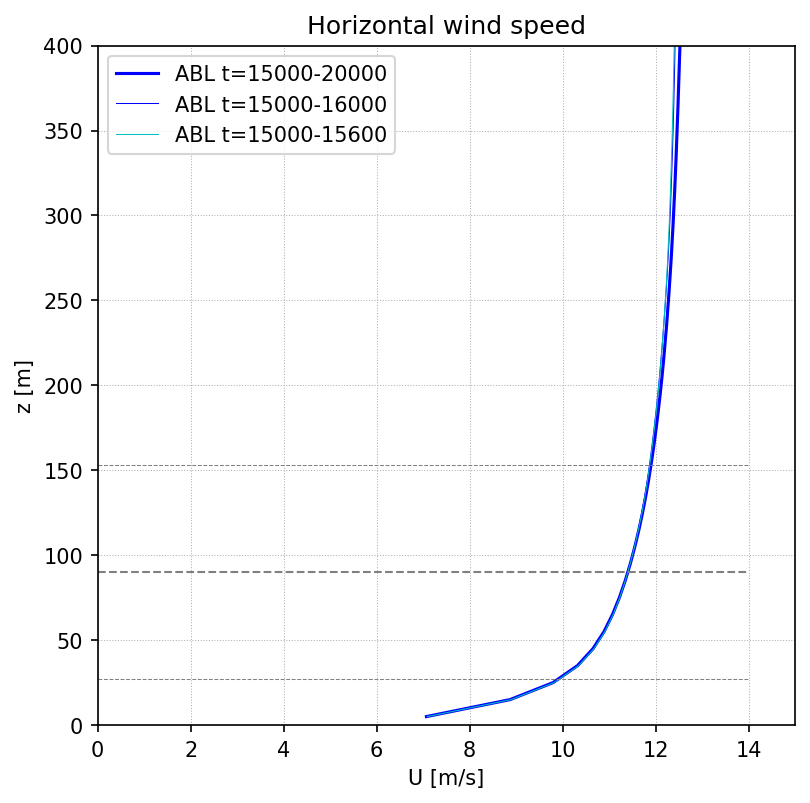

In [6]:
# Plot velocity
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)


# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Uhoriz'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    plt.plot(amrdat['Uhoriz']['data'], amrdat['Uhoriz']['z'], label=case['tag'], **lstyle)    
    if 'saveprefix' in case:
        savecsvdata(amrdat['Uhoriz'], {'z':'z', 'Uhoriz':'data'}, resultsdir+case['saveprefix']+'_Uhoriz.csv')
    
# Plot the turbine dimensions
plotrotorlines(zHH_target, rotorD, 0, 14, linestyles='dashed', color='gray',)

#ax.plot(ARM_WS, ARM_zHH, 's', color='r', label='Target')
ax.legend()
ax.set_xlim([0, 15])
ax.set_xlabel('U [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylim([0,400])
ax.set_ylabel('z [m]')
ax.set_title('Horizontal wind speed')

## Plot temperature profiles

Loading theta
Loading theta
Loading theta


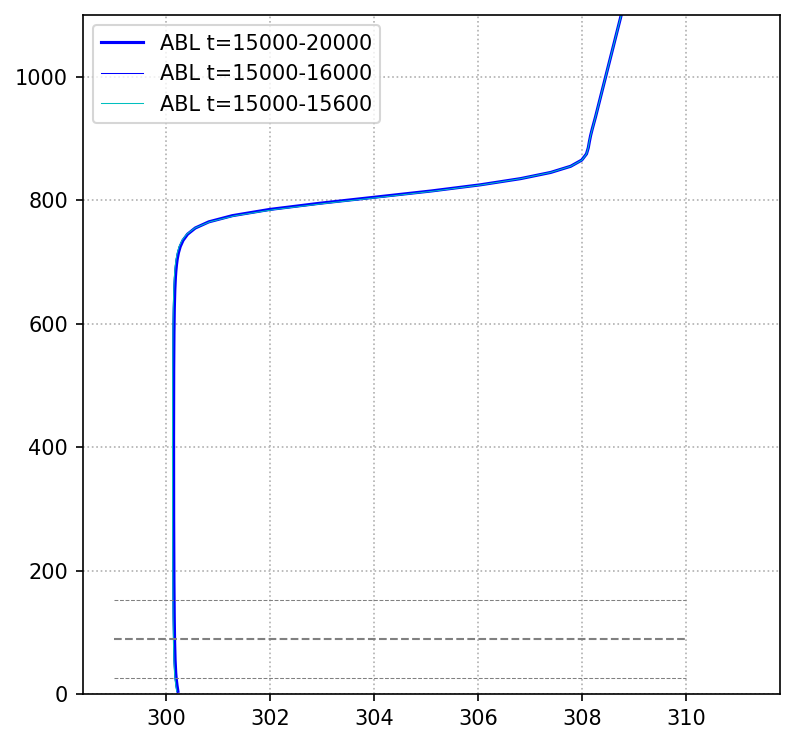

In [7]:
# Plot temperature
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Temperature'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    plt.plot(amrdat['T']['data'], amrdat['T']['z'], label=case['tag'], **lstyle)
    if 'saveprefix' in case:
        savecsvdata(amrdat['T'], {'z':'z', 'T':'data'}, resultsdir+case['saveprefix']+'_temperature.csv')

# Plot the turbine dimensions
plotrotorlines(zHH_target, rotorD, 299, 310, linestyles='dashed', color='gray',)

plt.ylim([0, 1100])
#plt.xlim([282, 295])
plt.grid(ls=':')
ax.legend()

## Plot veer profile

Loading u
Loading v
Loading u
Loading v
Loading u
Loading v


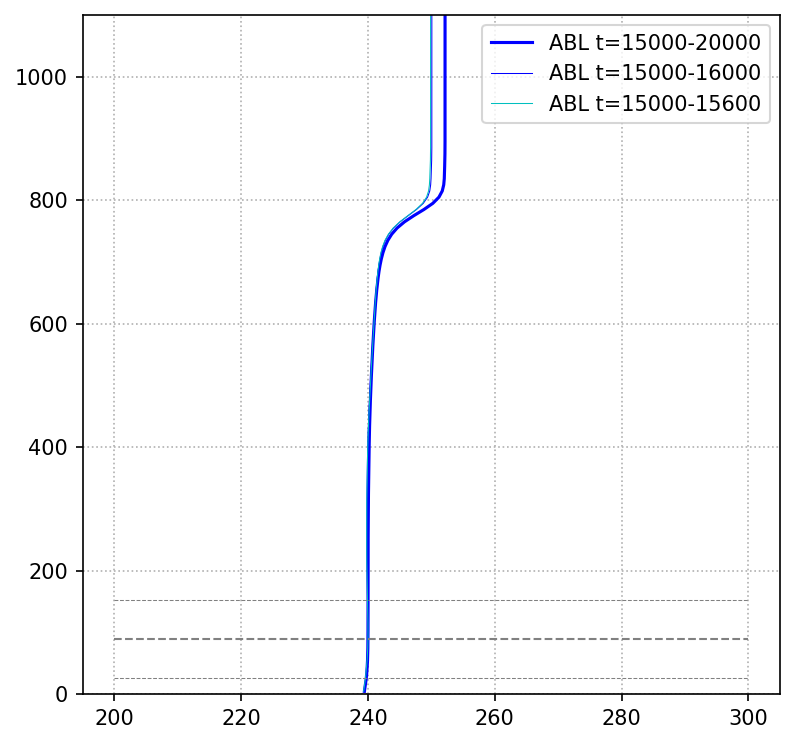

In [8]:
# Plot veer
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['WindDir'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    plt.plot(amrdat['WindDir']['data'], amrdat['WindDir']['z'], label=case['tag'], **lstyle)
    if 'saveprefix' in case:
        savecsvdata(amrdat['WindDir'], {'z':'z', 'WindDir':'data'}, resultsdir+case['saveprefix']+'_WindDir.csv')

# Plot the turbine dimensions
plotrotorlines(zHH_target, rotorD, 200, 300, linestyles='dashed', color='gray',)
plt.ylim([0, 1100]) #[0, 2000]
#plt.xlim([200, 280]) #[170, 190]
plt.grid(ls=':')
ax.legend()

## Plot TI

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r


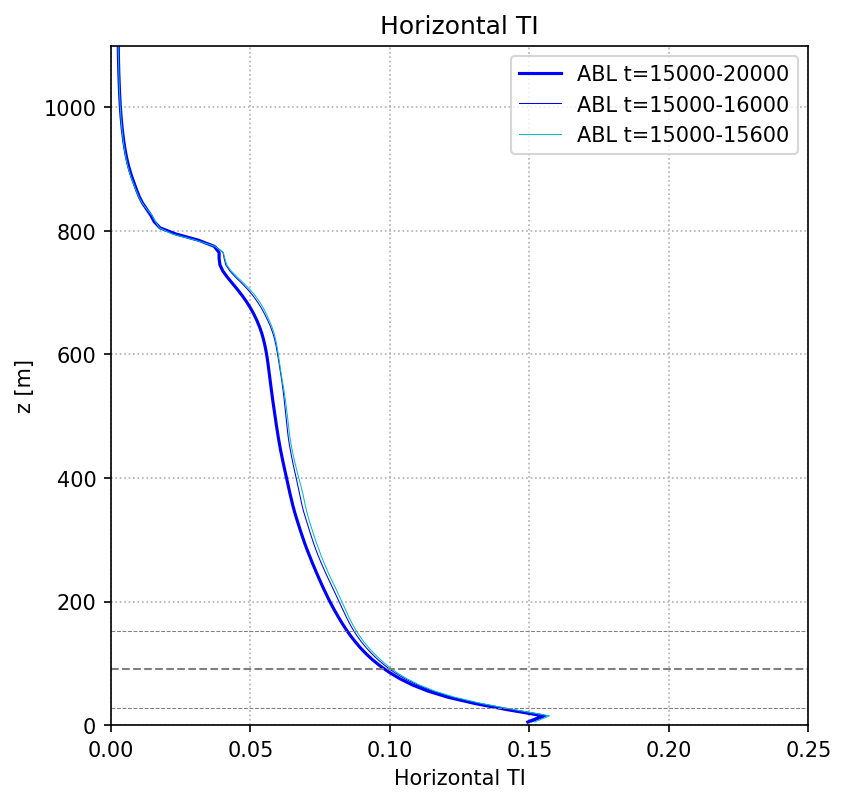

In [9]:
# Plot TI
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['TI_horiz'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    plt.plot(amrdat['TI_horiz']['data'], amrdat['TI_horiz']['z'], label=case['tag'], **lstyle)
    if 'saveprefix' in case:
        savecsvdata(amrdat['TI_horiz'], {'z':'z', 'TI_horiz':'data'}, resultsdir+case['saveprefix']+'_TIhoriz.csv')

# Plot the turbine dimensions
plotrotorlines(zHH_target, rotorD, 0, 1, linestyles='dashed', color='gray',)

plt.ylim([0, 1100])
plt.xlim([0, .25])
plt.grid(ls=':')
ax.set_ylabel('z [m]')
ax.set_xlabel('Horizontal TI')
ax.set_title('Horizontal TI')
ax.legend()

## Plot friction velocity

ustar
ustar
ustar


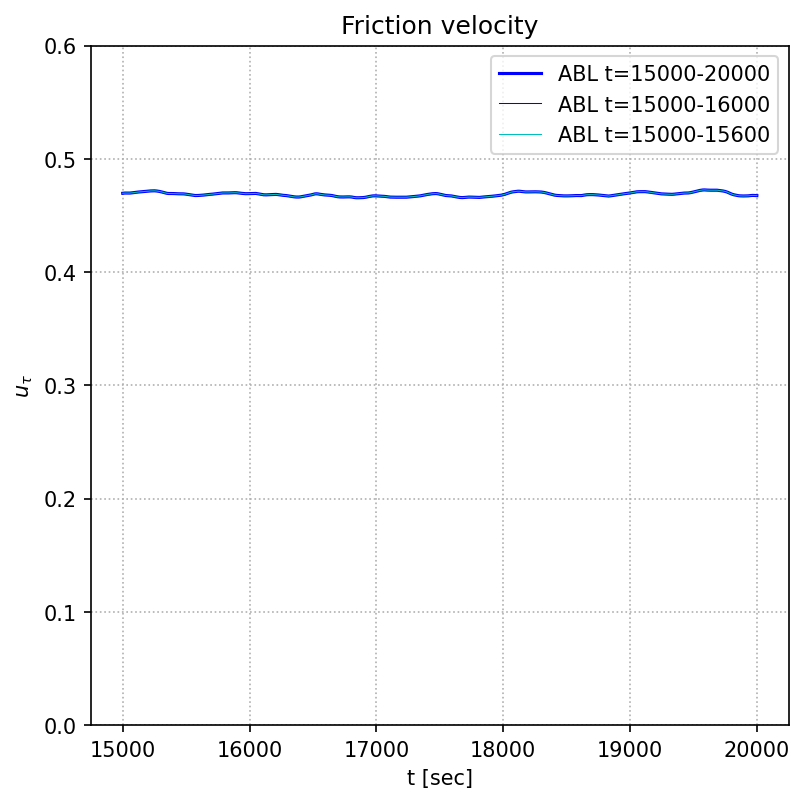

In [10]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotscalars(plotvars=['ustar'], doplot=False)
    lstyle=case['lstyle']
    plt.plot(amrdat['ustar']['t'], amrdat['ustar']['data'], label=case['tag'], **lstyle)
    if 'saveprefix' in case:
        savecsvdata(amrdat['ustar'], {'t':'t', 'ustar':'data'}, resultsdir+case['saveprefix']+'_ustar.csv')

plt.ylim([0, 0.6])
#plt.xlim([0, .25])
plt.grid(ls=':')
ax.set_ylabel('$u_{\\tau}$')
ax.set_xlabel('t [sec]')
ax.set_title('Friction velocity')
ax.legend()

## Plot Reynolds stresses

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


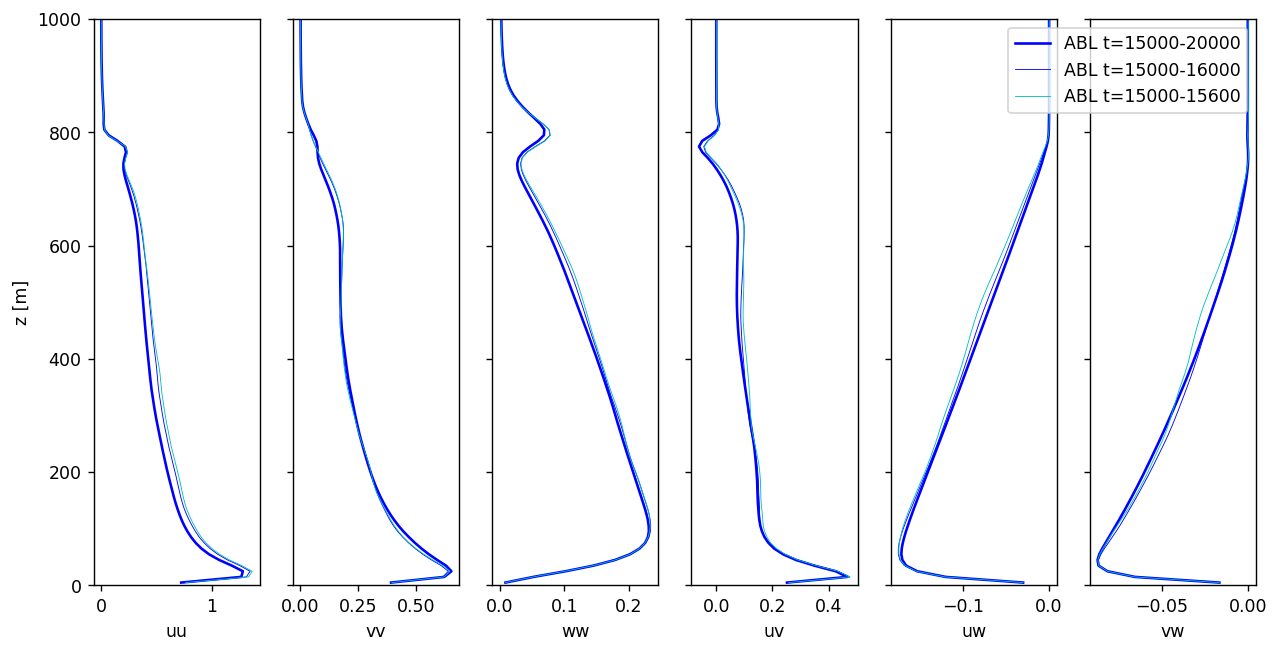

In [11]:
fig, axs = plt.subplots(1, 6,figsize=(12,6), facecolor='w', dpi=125, sharey=True)

plotvars = ['uu', 'vv', 'ww', 'uv', 'uw', 'vw']

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['ReStresses'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    for i, v in enumerate(plotvars):
        axs[i].plot(amrdat[v]['data'], amrdat[v]['z'], label=case['tag'], **lstyle)
        axs[i].set_xlabel(v)
        if 'saveprefix' in case:
            savecsvdata(amrdat[v], {'z':'z', v:'data'}, resultsdir+case['saveprefix']+'_%s.csv'%v)
    
axs[0].set_ylim([0,1000])
axs[0].set_ylabel('z [m]')
axs[-1].legend()

## Plot temperature fluxes

Loading u'theta'_r
Loading v'theta'_r
Loading w'theta'_r
Loading u'theta'_r
Loading v'theta'_r
Loading w'theta'_r
Loading u'theta'_r
Loading v'theta'_r
Loading w'theta'_r


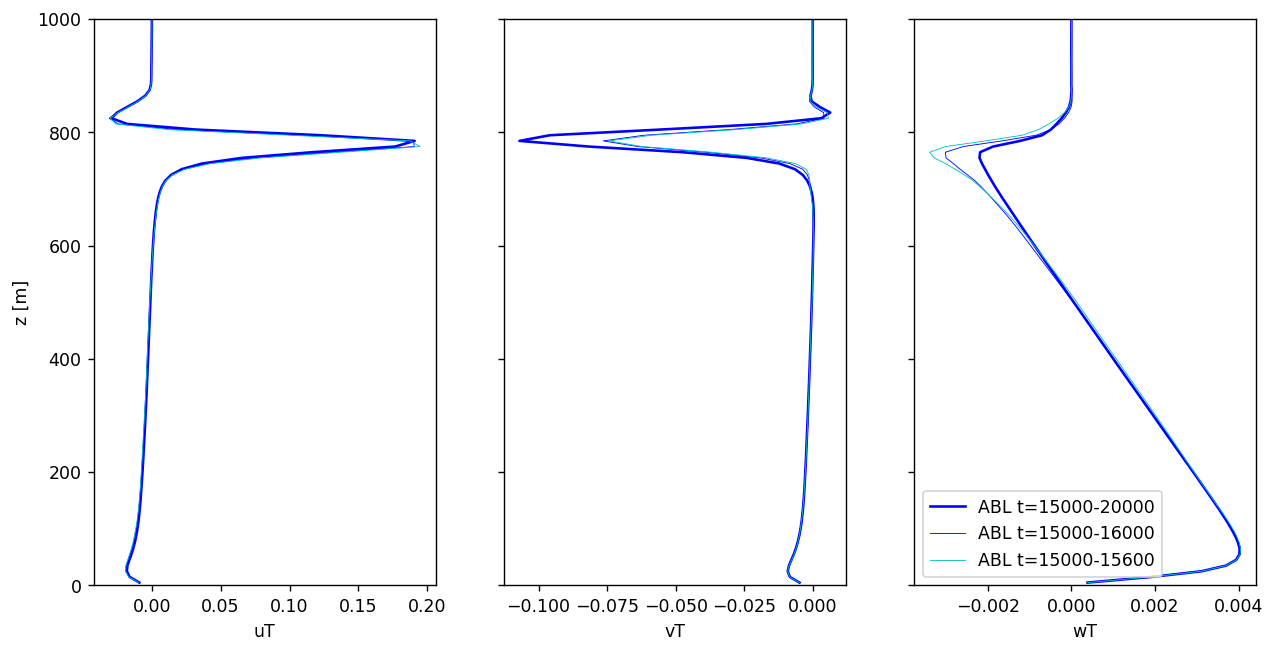

In [12]:
fig, axs = plt.subplots(1, 3,figsize=(12,6), facecolor='w', dpi=125, sharey=True)

plotvars = ['uT', 'vT', 'wT',]

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Tfluxes'], avgt=case['avgtimes'], doplot=False)
    lstyle=case['lstyle']
    for i, v in enumerate(plotvars):
        axs[i].plot(amrdat[v]['data'], amrdat[v]['z'], label=case['tag'], **lstyle)
        axs[i].set_xlabel(v)
        if 'saveprefix' in case:
            savecsvdata(amrdat[v], {'z':'z', v:'data'}, resultsdir+case['saveprefix']+'_%s.csv'%v)
    
axs[0].set_ylim([0,1000])
axs[0].set_ylabel('z [m]')
axs[-1].legend()